In [1]:
#3d wheat chloroplast segmentation of SBF-SEM images  
#This workflow was adapated from the "Python for microscoposts youtube series and git"
#https://github.com/bnsreenu/python_for_microscopists
#It is a fantastic resource for learning Python (specfically its capacity for image analysis)


In [2]:
import os
#Hash the below line of code to allow the GPU to be used (if you have alot of gpu memory)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
#Not all these packages are needed but some do really cool post segmentation stuff.
import numpy as np
import zipfile
import glob
import skimage.io as io
from skimage import img_as_ubyte, img_as_bool
from skimage.util import invert
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion
import skfmm
import random
import os
from pprint import pprint
from tqdm import tqdm
import joblib
import multiprocessing
import time
from pandas import DataFrame, Timestamp
from scipy import stats
import gc
import cv2
from os import listdir
from skimage.io import imread_collection
import matplotlib.pyplot as plt 
from skimage import color
from skimage import io
import pandas as pd
from scipy import stats
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image

Using TensorFlow backend.


In [4]:
print(tf.__version__)

2.1.0


In [5]:
#Next we need to set a working directory for the images (stored on google cloud)
os.chdir('F:/UNET/')

In [6]:
#We upload 3 different image stacks
#1 - the original SBFSEM image stacks
#2 - masks which correspond to #1
#3 - an untouched SBFSEM image stack 
#here 1 and 2 are from 2018 - we hand segmented chlorplasts 
#here 3 is a newly imaged (2020) wheat dataset 

In [7]:
#For U-net to run smoothly we resize all the images I found 1280 x 1280 works well
#The images can then be sampled back to their orgignial shape and therefore you can use the original voxel size
IMG_WIDTH = 2400
IMG_HEIGHT = 2400
IMG_CHANNELS = 1

In [8]:
#We then create a list of the ids 
train_ids = next(os.walk("images"))[2]
test_ids = next(os.walk("masks"))[2]
model_ids=next(os.walk("testm"))[2]


In [9]:
#We then create empty data frames which will be filled with the image data
#X_train is data #1 it will contain grey scale data
#Y_train is data #2 it will contain binary information (a pixel is or is not a chloroplast (TRUE or FALSE))

In [10]:
X_train = np.zeros((len(train_ids),  IMG_WIDTH,IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_WIDTH,IMG_HEIGHT, 1), dtype=np.bool)
#We then print the numbr of images to make sure we have the directories etc right 
print("No. of images = ", len(X_train ))
print("No. of images = ", len(Y_train ))


No. of images =  800
No. of images =  800


In [11]:
#lets load in image stack #1
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    # Load images
    img = load_img("images/"+id_, color_mode = "grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH , 1), mode = 'constant', preserve_range = True)
    X_train[n] = x_img  #Fill empty X_train with values from img

C:\Users\Richard\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


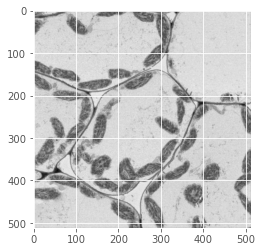

In [12]:
#and then plot an image to check 
plt.imshow(np.squeeze(X_train[0]), cmap="gray") 

In [13]:
#We now load in the masks (image stacks #2)
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    # Load images
    mask = load_img("masks/"+id_, color_mode = "grayscale")
    mask = img_to_array(mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH , 1), mode = 'constant', preserve_range = True)
    Y_train[n] =  mask  
    

C:\Users\Richard\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


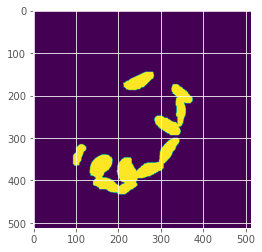

In [14]:
#and then plot an image to check
plt.imshow(np.squeeze(Y_train[0]))

In [15]:
#here we see that the yellow corresponds to chlorplasts

In [16]:
#lastly, image stack 3 is loaded and our goal is to use stacks 1 and 2 to idnetify and extract chlorplasts from image stack 3

In [17]:
X_test = np.zeros((len(model_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for n, id_ in tqdm_notebook(enumerate(model_ids), total=len(model_ids)):
    # Load images
    model = load_img("testm/"+id_, color_mode = "grayscale")
    m_img = img_to_array(model)
    m_img = resize(m_img, (IMG_HEIGHT, IMG_WIDTH , 1), mode = 'constant', preserve_range = True)
    X_test[n] = m_img  



C:\Users\Richard\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


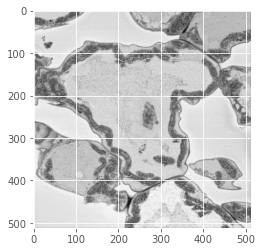

In [18]:
#We then plot stack 3, it is the same species but a different leaf - our assumption is the difference between leaves isnt
#large enough to make feauture extraction fail.
plt.imshow(np.squeeze(X_test[0]), cmap="gray")

In [19]:
#We now build the model which stems from this paper:
#U-Net: Convolutional Networks for Biomedical Image Segmentation https://arxiv.org/abs/1505.04597
#as stated in intro we edited the example from "Python for Microscopists"

In [20]:
#Build the model
inputs = tf.keras.layers.Input(( IMG_WIDTH,IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [21]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [22]:
#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [23]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
#This prints the model 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [25]:
#There are few key things to explore:
#batch size- The batch size defines the number of samples that will be propagated through the network. 
###https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

#epochs An epoch is a term used in machine learning and 
#indicates the number of passes of the entire training dataset the machine learning algorithm has completed

#validatin_split- how much of the data will be used to train and how much is used to validate


In [26]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('harwoodDLPYTHON.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        ModelCheckpoint('harwoodDLPYTHON.h5', verbose=1, save_best_only=True, save_weights_only=True)]

results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=100, callbacks=callbacks)

Train on 640 samples, validate on 160 samples
Epoch 1/100
624/640 [============================>.] - ETA: 13s - loss: 0.2157 - accuracy: 0.9194
Epoch 00001: val_loss improved from inf to 0.05840, saving model to harwoodDLPYTHON.h5
640/640 [==============================] - 584s 913ms/sample - loss: 0.2141 - accuracy: 0.9202 - val_loss: 0.0584 - val_accuracy: 1.0000
Epoch 2/100
624/640 [============================>.] - ETA: 13s - loss: 0.1199 - accuracy: 0.9536
Epoch 00002: val_loss improved from 0.05840 to 0.04070, saving model to harwoodDLPYTHON.h5
640/640 [==============================] - 565s 883ms/sample - loss: 0.1192 - accuracy: 0.9535 - val_loss: 0.0407 - val_accuracy: 1.0000
Epoch 3/100
624/640 [============================>.] - ETA: 12s - loss: 0.1204 - accuracy: 0.9532
Epoch 00003: val_loss improved from 0.04070 to 0.02046, saving model to harwoodDLPYTHON.h5
640/640 [==============================] - 513s 802ms/sample - loss: 0.1195 - accuracy: 0.9533 - val_loss: 0.0205 - v

In [27]:
preds_train = model.predict(X_train)
#preds_val = model.predict(X_train[int(X_train.shape[0]*1):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
#plt.imshow(X_test[0])


800/800 [==============================] - 117s 146ms/sample


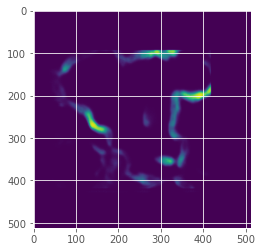

In [28]:
#print a randon predicted slice - brighter colours are more likely to be chl
plt.imshow(np.squeeze(preds_test[0]))

In [29]:
#This will write the images as a stack
from skimage.external import tifffile as tif
tif.imsave('THIS-IS-THE-UNET-MODEL.tif', preds_test, bigtiff=True)
tif.imsave('RAW.tif', X_test, bigtiff=True)


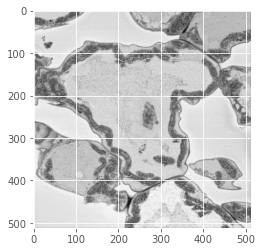

In [30]:
plt.imshow(np.squeeze(X_test[0]), cmap="gray")

In [31]:
#plot the original image again - It has done a good job in the centre but the outsides are quite blank - I ran it with
#higher resolution resize and it seemed to work better.

In [32]:
#We then need to go about making a binary image - I normal do this in FIJI or Avizo because i find thresholf exploration easier

In [33]:
#basically low pixels values are less likely to be a chl and higher are more likely 
#
preds_test_t = (preds_test > 0.01).astype(np.uint8)

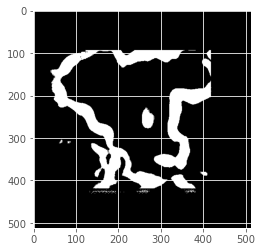

In [34]:
plt.imshow(np.squeeze(preds_test_t[0]), cmap="gray")

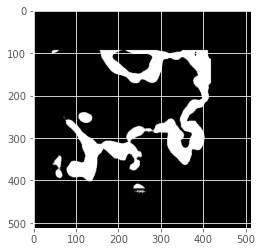

In [36]:
plt.imshow(np.squeeze(preds_test_t[550]), cmap="gray") #slice 550

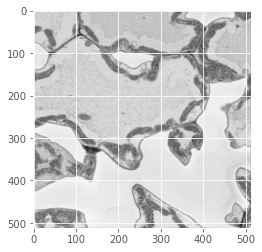

In [37]:
plt.imshow(np.squeeze(X_test[550]), cmap="gray")